In [1]:
import os
import random
import torch.nn as nn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from torch import optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import torch
from imblearn.over_sampling import SMOTE
from IPython.display import clear_output
from sklearn.decomposition import PCA
from pytorch_metric_learning import losses, miners
# import re
# from torchsampler import ImbalancedDatasetSampler
# import shap
# from sklearn.preprocessing import MinMaxScaler
# import math
# import time
# import json
# from datetime import datetime
# from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")


In [2]:
seed = 30
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# 40, 27 = 0.76 
#  = 0.72
#  = 0.8

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print(device)

cuda:0


In [4]:
LLM = "bert-base-uncased"
# LLM = "bert-large-uncased"
# LLM = "albert"
# LLM = "roberta"
# LLM = "xlm"

In [5]:
lv1_lv3 = dict({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:2, 17:2, 18:2})

In [6]:
class DATA():

    def __init__(self):
        self.dataset_llm = []
        self.dataset_opensmile = []
        self.dataset_cps_f = []
        self.dataset_cps_i = []
        self.dataset_action = []
        self.dataset_gamr = []

        self.targets = []

    def openLLM(self, filename):
        data = pd.read_csv(filename)
        for i in range(len(data)):
            self.dataset_llm.append(np.asarray(data.iloc[i]).tolist())
        global llm_size
        llm_size = len(self.dataset_llm[-1])
    
    
    def openSmile(self,filename):
        data = pd.read_csv(filename)
        for i in range (data.shape[0]):
            # print(f'C:\\Users\\Bbykitty\\OneDrive - Colostate\\Research\\Initial Observations for Fib Weights\\Data\\Segment Analysis\\{filename[filename.index("Group_"):filename.index("Group_")+8]}\\segments_oracle\\{filename[filename.index("Group_"):filename.index("Group_")+8]}_'+str(i)+'.wav')
            row=data[data['file']==f'C:\\Users\\bradf\\OneDrive - Colostate\\Research\\Initial Observations for Fib Weights\\Data\\Segment Analysis\\{filename[filename.index("Group_"):filename.index("Group_")+8]}\\segments_oracle\\{filename[filename.index("Group_"):filename.index("Group_")+8]}_'+str(i)+'.wav']
            tensor=np.nan_to_num(np.asarray(row.values[0][3:91],dtype=np.float32)).tolist()
            self.dataset_opensmile.append(tensor)


    def openCPS(self, filename):
        data = pd.read_csv(filename).fillna(0)
        for row in range(data.shape[0]):
            cps = data.iloc[row, 8:].fillna(0)
            self.dataset_cps_i.append(list(cps.values))
            cps_f = [0, 0, 0]
            for i, c in enumerate(list(cps.values)):
                if c == 1:
                    cps_f[lv1_lv3[i]] = 1
            self.dataset_cps_f.append(cps_f)

    def openAction(self, filename):
        data = pd.read_csv(filename, header=None).fillna(0)
        for row in range(data.shape[0]):
            self.dataset_action.append(data.iloc[row].to_list())



    def openGAMR(self, filename):
        data = pd.read_csv(filename, header=None).fillna(0)
        for row in range(data.shape[0]):
            self.dataset_gamr.append(data.iloc[row].to_list())
        

    def openTarget(self,filename):
        data = pd.read_csv(filename)
        for row in range(data.shape[0]):
            target = data.iloc[row, 3:].values.astype(int)
            self.targets.append(target.tolist())


    def get_datasets(self, rand=False):
        final_dataset=[]        
        for llm, opensmile, cps_f, cps_i, action, gamr, label in zip(self.dataset_llm, self.dataset_opensmile,self.dataset_cps_f, self.dataset_cps_i, self.dataset_action, self.dataset_gamr, self.targets):
            final_dataset.append([llm, opensmile, cps_f, cps_i, action, gamr, label])
            
        if rand:
            random.shuffle(final_dataset)
        return final_dataset

In [39]:
def read_data(dataset, root, file, llm="bert-base-uncased"):

    if llm in file:
        dataset.openLLM(root+"/"+file)
    if 'oracle_opensmile' in file:
        dataset.openSmile(root+"/"+file)
    elif 'CPS_Oracle' in file:
        dataset.openCPS(root+"/"+file)
    elif "Actions_Oracle_vectors" in file:
        dataset.openAction(root+"/"+file)
    elif "GAMR_Oracle_vectors" in file:
        dataset.openGAMR(root+"/"+file)
    elif 'CG_3_gold.csv' in file:
        dataset.openTarget(root+"/"+file)
        

In [40]:
train_datasets = DATA()

In [41]:
for root, dirs,files in (os.walk(os. getcwd())):
    if "Group_" in root and "data" not in root:
        if "asr" not in root:
            print(root)
            for file in files:
                read_data(train_datasets, root, file, LLM)

/s/chopin/b/grad/benkh/Common Ground/Group_05
/s/chopin/b/grad/benkh/Common Ground/Group_07
/s/chopin/b/grad/benkh/Common Ground/Group_06
/s/chopin/b/grad/benkh/Common Ground/Group_02
/s/chopin/b/grad/benkh/Common Ground/Group_09
/s/chopin/b/grad/benkh/Common Ground/Group_03
/s/chopin/b/grad/benkh/Common Ground/Group_10
/s/chopin/b/grad/benkh/Common Ground/Group_08
/s/chopin/b/grad/benkh/Common Ground/Group_01
/s/chopin/b/grad/benkh/Common Ground/Group_04


In [42]:
len(train_datasets.dataset_llm) == len(train_datasets.dataset_opensmile) == len(train_datasets.dataset_cps_f) == len(train_datasets.dataset_cps_i) == len(train_datasets.dataset_action) == len(train_datasets.dataset_gamr) == len(train_datasets.targets)

True

In [43]:
np.sum(np.asarray(train_datasets.targets))

271

In [44]:
np.sum(np.asarray(train_datasets.targets), axis=0)

array([195,  61,  15])

In [45]:
def change_window_size(train_list, window_size):
    rec_train_list = []
    pad = [[0]*len(train_list[0][0]), [0]*len(train_list[0][1])]

    for utt_id in range(len(train_list)):
        aux = []
        for i in range(window_size):
            if utt_id == i:
                for _ in range(window_size-utt_id):
                    aux.append(pad)
        for i in range(window_size):
            if len(aux) == i:
                aux.append(train_list[utt_id - window_size + i])
        aux.append(train_list[utt_id])
        rec_train_list.append(aux)
    
    return rec_train_list

In [46]:
window_size = 3

In [47]:
def get_data(k, j, window_size):
    full_data = []
    for group in range(1, 11):
        if group != k and group != j:
            train_datasets = DATA()
            for root, dirs,files in (os.walk(os. getcwd())):
                if f"Group_{group:02d}" in root and "data" not in root:
                    if "asr" not in root:
                        print(root)
                        for file in files:
                            read_data(train_datasets, root, file, LLM)
            train_list = train_datasets.get_datasets()
            train_list = [[a+b+c+d+e+f, g] for a,b,c,d,e,f,g in train_list]
            rec_train_list = change_window_size(train_list, window_size)
            full_data += rec_train_list
        # random.shuffle(full_data)
    return full_data

In [48]:
def get_group_k(k, window_size):
    full_data = []
    group = k
    train_datasets = DATA()
    for root, dirs,files in (os.walk(os. getcwd())):
        if f"Group_{group:02d}" in root and "data" not in root:
            if "asr" not in root:
                print(root)
                for file in files:
                    read_data(train_datasets, root, file, LLM)
    train_list = train_datasets.get_datasets()
    train_list = [[a+b+c+d+e+f, g] for a,b,c,d,e,f,g in train_list]
    rec_train_list = change_window_size(train_list, window_size)
    full_data += rec_train_list
    # random.shuffle(full_data)
    return full_data

In [49]:
# Uncomment to remove utterances with no CGA
def remove_non_cga(full_data):
    utt_id = 0
    while utt_id  < (len(full_data)):
        if full_data[utt_id][-1][1] == [0, 0, 0]:
            del full_data[utt_id]
        else:
            utt_id += 1
    return full_data

In [50]:
test_group = 2 # Must hold out group 2 (it contains 1 of each class which we need for auroc)
val_group = 5
train_data = get_data(test_group, val_group, window_size)
test_data = get_group_k(test_group, window_size)
val_data = get_group_k(val_group, window_size)

/s/chopin/b/grad/benkh/Common Ground/Group_01
/s/chopin/b/grad/benkh/Common Ground/Group_03
/s/chopin/b/grad/benkh/Common Ground/Group_04
/s/chopin/b/grad/benkh/Common Ground/Group_06
/s/chopin/b/grad/benkh/Common Ground/Group_07
/s/chopin/b/grad/benkh/Common Ground/Group_08
/s/chopin/b/grad/benkh/Common Ground/Group_09
/s/chopin/b/grad/benkh/Common Ground/Group_10
/s/chopin/b/grad/benkh/Common Ground/Group_02
/s/chopin/b/grad/benkh/Common Ground/Group_05


In [51]:
train_data = remove_non_cga(train_data)
test_data = remove_non_cga(test_data)
val_data = remove_non_cga(val_data)

In [52]:
class rec_dataset(Dataset):
    def __init__(self,xy=None, window_size=3):
        self.utt_bert_l = []
        self.utt_open_l = []
        self.utt_cps_f_l = []
        self.utt_cps_i_l = []
        self.utt_action_l = []
        self.utt_gamr_l = []
        self.utt_y_l = []
        self.utt_y = []

        for utt in xy:
            bert_tmp = []
            open_tmp = []
            cps_i_tmp = []
            cps_f_tmp = []
            action_tmp = []
            gamr_tmp = []
            y_tmp = []
            for utt_id in range(window_size+1):
                bert_tmp.append(utt[utt_id][0][:llm_size])
                open_tmp.append(utt[utt_id][0][llm_size:llm_size+88])
                cps_i_tmp.append(utt[utt_id][0][llm_size+88:llm_size+88+19])
                cps_f_tmp.append(utt[utt_id][0][llm_size+88+19:llm_size+88+19+3])
                action_tmp.append(utt[utt_id][0][llm_size+88+19+3:llm_size+88+19+3+78])
                gamr_tmp.append(utt[utt_id][0][llm_size+88+19+3+78:])
                y_tmp.append(utt[utt_id][1])
            self.utt_bert_l.append(bert_tmp)
            self.utt_open_l.append(open_tmp)
            self.utt_cps_f_l.append(cps_f_tmp)
            self.utt_cps_i_l.append(cps_i_tmp)
            self.utt_action_l.append(action_tmp)
            self.utt_gamr_l.append(gamr_tmp)
            self.utt_y_l.append(y_tmp)
        self.utt_bert_l = torch.from_numpy(np.asarray(self.utt_bert_l,dtype=np.float32))
        self.utt_open_l = torch.from_numpy(np.asarray(self.utt_open_l,dtype=np.float32))
        self.utt_cps_f_l = torch.from_numpy(np.asarray(self.utt_cps_f_l,dtype=np.float32))
        self.utt_cps_i_l = torch.from_numpy(np.asarray(self.utt_cps_i_l,dtype=np.float32))
        self.utt_action_l = torch.from_numpy(np.asarray(self.utt_action_l,dtype=np.float32))
        self.utt_gamr_l = torch.from_numpy(np.asarray(self.utt_gamr_l,dtype=np.float32))
        self.utt_y_l = torch.from_numpy(np.asarray(self.utt_y_l,dtype=np.float32))

        for utt_id in range(len(self.utt_y_l)):
            self.utt_y.append(self.utt_y_l[utt_id][-1])

        self.len=len(self.utt_bert_l)
        

    def __getitem__(self, index):
        return self.utt_bert_l[index], self.utt_open_l[index], self.utt_cps_f_l[index], self.utt_cps_i_l[index], self.utt_action_l[index], self.utt_gamr_l[index], self.utt_y[index]
    
    def get_labels(self):
        return np.stack(self.utt_y, axis=0).argmax(axis=1)

    def __len__(self):
        return self.len

In [64]:
train_dataset = rec_dataset(train_data, window_size)
test_dataset = rec_dataset(test_data, window_size)
val_dataset = rec_dataset(val_data, window_size)

In [65]:
def smote_preprocess(train_dataset, window_size):
    x_bert = []
    x_open = []
    x_cps_i = []
    x_cps_f = []
    x_action = []
    x_gamr = []
    y = []
    for i in range(len(train_dataset)):
        x_bert_tmp = []
        x_open_tmp = []
        x_cps_i_tmp = []
        x_cps_f_tmp = []
        x_action_tmp = []
        x_gamr_tmp = []
        for j in range(len(train_dataset.utt_open_l[i])):
            x_bert_tmp += train_dataset.utt_bert_l[i][j].tolist()
            x_open_tmp += train_dataset.utt_open_l[i][j].tolist()
            x_cps_i_tmp += train_dataset.utt_cps_i_l[i][j].tolist()
            x_cps_f_tmp += train_dataset.utt_cps_f_l[i][j].tolist()
            x_action_tmp += train_dataset.utt_action_l[i][j].tolist()
            x_gamr_tmp += train_dataset.utt_gamr_l[i][j].tolist()

        y.append(train_dataset.utt_y[i].tolist())
        x_bert.append(x_bert_tmp)
        x_open.append(x_open_tmp)
        x_cps_i.append(x_cps_i_tmp)
        x_cps_f.append(x_cps_f_tmp)
        x_action.append(x_action_tmp)
        x_gamr.append(x_gamr_tmp)

        # if y[-1] == [0, 0, 1]:
        #     for _ in range(2):
        #         y.append(train_dataset.utt_y[i].tolist())
        #         x_bert.append(x_bert_tmp)
        #         x_open.append(x_open_tmp)
        #         x_cps_i.append(x_cps_i_tmp)
        #         x_cps_f.append(x_cps_f_tmp)
        #         x_action.append(x_action_tmp)
        #         x_gamr.append(x_gamr_tmp)
        

    oversample = SMOTE()

    x_bert, y_ = oversample.fit_resample(np.array(x_bert), np.array(y))
    x_open, y_ = oversample.fit_resample(np.array(x_open), np.array(y))
    x_cps_i, y_ = oversample.fit_resample(np.array(x_cps_i), np.array(y))
    x_cps_f, y_ = oversample.fit_resample(np.array(x_cps_f), np.array(y))
    x_action, y_ = oversample.fit_resample(np.array(x_action), np.array(y))
    x_gamr, y_ = oversample.fit_resample(np.array(x_gamr), np.array(y))
    clear_output(wait=False)



    x_bert_tensor = []
    x_open_tensor = []
    x_cps_i_tensor = []
    x_cps_f_tensor = []
    x_action_tensor = []
    x_gamr_tensor = []
    y = []
    for i in range(len(x_bert)):
        x_bert_tmp = []
        x_open_tmp = []
        x_cps_i_tmp = []
        x_cps_f_tmp = []
        x_action_tmp = []
        x_gamr_tmp = []
        for utt_id in range(window_size+1):
            bert_size = int(len(x_bert[i])/(window_size + 1))
            open_size = int(len(x_open[i])/(window_size + 1))
            cps_i_size = int(len(x_cps_i[i])/(window_size + 1))
            cps_f_size = int(len(x_cps_f[i])/(window_size + 1))
            action_size = int(len(x_action[i])/(window_size + 1))
            gamr_size = int(len(x_gamr[i])/(window_size + 1))

            x_bert_tmp.append(x_bert[i][utt_id*bert_size:(utt_id+1)*bert_size])
            x_open_tmp.append(x_open[i][utt_id*open_size:(utt_id+1)*open_size])
            x_cps_i_tmp.append(x_cps_i[i][utt_id*cps_i_size:(utt_id+1)*cps_i_size])
            x_cps_f_tmp.append(x_cps_f[i][utt_id*cps_f_size:(utt_id+1)*cps_f_size])
            x_action_tmp.append(x_action[i][utt_id*action_size:(utt_id+1)*action_size])
            x_gamr_tmp.append(x_gamr[i][utt_id*gamr_size:(utt_id+1)*gamr_size])

        x_bert_tensor.append(x_bert_tmp)
        x_open_tensor.append(x_open_tmp)
        x_cps_i_tensor.append(x_cps_i_tmp)
        x_cps_f_tensor.append(x_cps_f_tmp)
        x_action_tensor.append(x_action_tmp)
        x_gamr_tensor.append(x_gamr_tmp)
        y.append(torch.Tensor(y_[i]))

    x_bert_tensor = torch.from_numpy(np.array(x_bert_tensor, dtype=np.float32))
    x_open_tensor = torch.from_numpy(np.array(x_open_tensor, dtype=np.float32))
    x_cps_i_tensor = torch.from_numpy(np.array(x_cps_i_tensor, dtype=np.float32))
    x_cps_f_tensor = torch.from_numpy(np.array(x_cps_f_tensor, dtype=np.float32))
    x_action_tensor = torch.from_numpy(np.array(x_action_tensor, dtype=np.float32))
    x_gamr_tensor = torch.from_numpy(np.array(x_gamr_tensor, dtype=np.float32))


    train_dataset.utt_bert_l = x_bert_tensor
    train_dataset.utt_open_l = x_open_tensor
    train_dataset.utt_cps_i_l = x_cps_i_tensor
    train_dataset.utt_cps_f_l = x_cps_f_tensor
    train_dataset.utt_action_l = x_action_tensor
    train_dataset.utt_gamr_l = x_gamr_tensor
    train_dataset.utt_y = y
    train_dataset.len = len(train_dataset.utt_y)

In [66]:
# y_train = rec_dataset(rec_train_list, window_size).utt_y
y_train = train_dataset.utt_y

In [67]:
y_train_tensor = torch.stack(y_train)

In [68]:
print(y_train_tensor.argmax(dim=1).unique(return_counts=True))

(tensor([0, 1, 2]), tensor([149,  49,  14]))


In [69]:
smote_preprocess(train_dataset, window_size)

In [70]:
# rec_train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset),batch_size=16)
# rec_test_loader = DataLoader(dataset=test_dataset, sampler=ImbalancedDatasetSampler(test_dataset),batch_size=16)
rec_train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
rec_test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)
rec_val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

In [71]:
# y_train = rec_dataset(rec_train_list, window_size).utt_y
y_train = train_dataset.utt_y

In [72]:
y_train_tensor = torch.stack(y_train)

In [73]:
print(y_train_tensor.argmax(dim=1).unique(return_counts=True))

(tensor([0, 1, 2]), tensor([149, 149, 149]))


In [28]:
class rec_common_ground(nn.Module):
    def __init__(self, hyperparam, modalities, output_size=1):
        super(rec_common_ground, self).__init__()

        lin_layers = hyperparam["lin_layers"]
        hidden_size = hyperparam["hidden_size"]
        lstm_hidden_size = hyperparam["lstm_hidden_size"]
        lstm_input_size = hyperparam["lstm_input_size"]
        ff1_size = hyperparam["ff1_size"]
        ff2_size = hyperparam["ff2_size"]

        bert_b = modalities["bert_b"]
        opensmile_b = modalities["opensmile_b"]
        cps_b = modalities["cps_b"]
        cps_f_b = modalities["cps_f_b"]
        action_b = modalities["action_b"]
        gamr_b = modalities["gamr_b"]

        self.lin_bert1 = nn.Linear(llm_size, hidden_size)
        self.lin_bert2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_bert = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_bert = nn.LSTM(input_size=llm_size, batch_first=True, hidden_size=lstm_hidden_size)


        self.lin_open1 = nn.Linear(88, hidden_size)
        self.lin_open2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_opensmile = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_opensmile = nn.LSTM(input_size=88, batch_first=True, hidden_size=lstm_hidden_size)

        cps_size = 19
        if cps_f_b:
            cps_size = 3
        self.lin_cps1 = nn.Linear(cps_size, hidden_size)
        self.lin_cps2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_cps = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_cps = nn.LSTM(input_size=cps_size, batch_first=True, hidden_size=lstm_hidden_size)


        self.lin_action1 = nn.Linear(78, hidden_size)
        self.lin_action2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_action = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_action = nn.LSTM(input_size=78, batch_first=True, hidden_size=lstm_hidden_size)

        self.lin_gamr1 = nn.Linear(243, hidden_size)
        self.lin_gamr2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_gamr = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_gamr = nn.LSTM(input_size=243, batch_first=True, hidden_size=lstm_hidden_size)


        self.relu = nn.ReLU()
        n_modals = int(bert_b) + int(opensmile_b) + int(cps_b) + int(action_b) + int(gamr_b)
        self.ff1 = nn.Linear(lstm_hidden_size*n_modals, ff1_size)
        self.ff2 = nn.Linear(ff1_size, ff2_size)
        self.act1 = nn.Tanh()
        self.act2 = nn.SiLU()
        self.classifier = nn.Linear(ff2_size, output_size)


    def forward(self, utt_bert_l, utt_open_l, utt_cps_l, utt_action_l, utt_gamr_l, hyperparam, modalities):


        lin_layers = hyperparam["lin_layers"]
        bert_b = modalities["bert_b"]
        opensmile_b = modalities["opensmile_b"]
        cps_b = modalities["cps_b"]
        cps_f_b = modalities["cps_f_b"]
        action_b = modalities["action_b"]
        gamr_b = modalities["gamr_b"]


        if bert_b:
            if lin_layers:
                utt_bert_l = [self.lin_bert1(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.lin_bert2(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.relu(utt_x_bert) for utt_x_bert in utt_bert_l]
            bert = torch.stack(tuple(utt_bert_l), dim=0)
            bert = self.lstm_bert(bert)[1][0][0]

        if opensmile_b:
            if lin_layers:
                utt_open_l = [self.lin_open1(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.lin_open2(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.relu(utt_x_open) for utt_x_open in utt_open_l]
            opensmile = torch.stack(tuple(utt_open_l), dim=0)
            opensmile = self.lstm_opensmile(opensmile)[1][0][0]

        if cps_b:
            if lin_layers:
                utt_cps_l = [self.lin_cps1(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.lin_cps2(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.relu(utt_x_cps) for utt_x_cps in utt_cps_l]
                # utt_cps_l shape = batch_size, window_size+1, 256
            cps = torch.stack(tuple(utt_cps_l), dim=0)
            cps = self.lstm_cps(cps)[1][0][0]

        if action_b:
            if lin_layers:
                utt_action_l = [self.lin_action1(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.lin_action2(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.relu(utt_x_action) for utt_x_action in utt_action_l]
            action = torch.stack(tuple(utt_action_l), dim=0)
            action = self.lstm_action(action)[1][0][0]

        if gamr_b:
            if lin_layers:
                utt_gamr_l = [self.lin_gamr1(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.lin_gamr2(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.relu(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
            gamr = torch.stack(tuple(utt_gamr_l), dim=0)
            gamr = self.lstm_gamr(gamr)[1][0][0]

        modals = []
        if bert_b: modals.append(bert)
        if opensmile_b: modals.append(opensmile)
        if cps_b: modals.append(cps)
        if action_b: modals.append(action)
        if gamr_b: modals.append(gamr)


        x = torch.hstack(tuple(modals))
        x = self.ff1(x)
        x = self.act1(x)
        x = self.ff2(x)
        x = self.act2(x)
        predict = self.classifier(x)

        return predict


    def get_embeddings(self, utt_bert_l, utt_open_l, utt_cps_l, utt_action_l, utt_gamr_l, hyperparam, modalities):


        lin_layers = hyperparam["lin_layers"]
        bert_b = modalities["bert_b"]
        opensmile_b = modalities["opensmile_b"]
        cps_b = modalities["cps_b"]
        cps_f_b = modalities["cps_f_b"]
        action_b = modalities["action_b"]
        gamr_b = modalities["gamr_b"]


        if bert_b:
            if lin_layers:
                utt_bert_l = [self.lin_bert1(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.lin_bert2(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.relu(utt_x_bert) for utt_x_bert in utt_bert_l]
            bert = torch.stack(tuple(utt_bert_l), dim=0)
            bert = self.lstm_bert(bert)[1][0][0]

        if opensmile_b:
            if lin_layers:
                utt_open_l = [self.lin_open1(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.lin_open2(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.relu(utt_x_open) for utt_x_open in utt_open_l]
            opensmile = torch.stack(tuple(utt_open_l), dim=0)
            opensmile = self.lstm_opensmile(opensmile)[1][0][0]

        if cps_b:
            if lin_layers:
                utt_cps_l = [self.lin_cps1(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.lin_cps2(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.relu(utt_x_cps) for utt_x_cps in utt_cps_l]
                # utt_cps_l shape = batch_size, window_size+1, 256
            cps = torch.stack(tuple(utt_cps_l), dim=0)
            cps = self.lstm_cps(cps)[1][0][0]

        if action_b:
            if lin_layers:
                utt_action_l = [self.lin_action1(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.lin_action2(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.relu(utt_x_action) for utt_x_action in utt_action_l]
            action = torch.stack(tuple(utt_action_l), dim=0)
            action = self.lstm_action(action)[1][0][0]

        if gamr_b:
            if lin_layers:
                utt_gamr_l = [self.lin_gamr1(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.lin_gamr2(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.relu(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
            gamr = torch.stack(tuple(utt_gamr_l), dim=0)
            gamr = self.lstm_gamr(gamr)[1][0][0]

        modals = []
        if bert_b: modals.append(bert)
        if opensmile_b: modals.append(opensmile)
        if cps_b: modals.append(cps)
        if action_b: modals.append(action)
        if gamr_b: modals.append(gamr)


        x = torch.hstack(tuple(modals))
        x = self.ff1(x)
        x = self.act1(x)
        x = self.ff2(x)
        x = self.act2(x)

        return x


In [29]:
def rec_train(model, total_epochs, lr, train_loader, class_to_eval, hyperparam, modalities, output_size):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_loss = []
    nepochs = 0
    cps_f_b = modalities["cps_f_b"]
    model.train()

    criterion = nn.BCELoss(reduction='mean').to(device)
    if output_size != 1:
        # criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
    while nepochs < total_epochs :
        batch_loss = []
        for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in train_loader:
            utt_cps_l = utt_cps_f_l
            if not cps_f_b:
                utt_cps_l = utt_cps_i_l
            output = model(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
            # target = utt_y_l[-1].to(device)
            target = utt_y.to(device)
            if output_size == 1:
                target_binary = torch.zeros(target.size()[0], 1).to(device)
                for i,t in enumerate(target):
                    target_binary[i] = torch.Tensor([t[class_to_eval]])
                loss = criterion(torch.sigmoid(output), target_binary)
            else:
                loss = criterion(output, target)
            batch_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        nepochs += 1
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
    return model, epoch_loss

In [30]:
def rec_test(model, test_loader, class_to_eval, hyperparam, modalities, output_size):
    with torch.no_grad():
        model.eval()
        cps_f_b = modalities["cps_f_b"]
        true, pred = None, None
        for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in test_loader:
            utt_cps_l = utt_cps_f_l
            if not cps_f_b:
                utt_cps_l = utt_cps_i_l
            output = model(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
            # target = utt_y_l[-1].to(device)
            target = utt_y.to(device)
            if output_size == 1:
                pred_tmp = torch.sigmoid(output)
                true_binary = torch.zeros(target.size()[0], 1)
                for i, t in enumerate(target):
                    true_binary[i] = torch.Tensor([t[class_to_eval]])
                if true == None:
                    true = true_binary
                    pred = pred_tmp > 0.5
                    pred_probs = pred_tmp

                else :
                    true = torch.cat((true, true_binary))
                    pred = torch.cat((pred, pred_tmp > 0.5))
                    pred_probs = torch.cat((pred_probs, pred_tmp))
                    
            
            else:
                softmax = torch.nn.Softmax(dim=1)
                target_ = torch.clone(target)
                true_tmp = target_.cpu().numpy()
                preds_tmp = softmax(output).cpu().detach().numpy()

                if true == None:
                    true = torch.argmax(torch.from_numpy(true_tmp), dim=1)
                    pred = torch.argmax(torch.from_numpy(preds_tmp), dim=1)
                    pred_probs = torch.tensor(preds_tmp)
                else:
                    true = torch.cat((true, torch.argmax(torch.from_numpy(true_tmp), dim=1)))
                    pred = torch.cat((pred, torch.argmax(torch.from_numpy(preds_tmp), dim=1)))
                    pred_probs = torch.cat((pred_probs, torch.tensor(preds_tmp)))
        
    return true.int().cpu(), pred.int().cpu(), pred_probs.cpu()


In [31]:
def triplet_train(model, total_epochs, lr, train_loader, hyperparam, modalities, output_size):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_loss = []
    cps_f_b = modalities["cps_f_b"]
    model.train()
    # miner = miners.MultiSimilarityMiner()
    loss_func = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)
    loss_func = losses.AngularLoss(alpha=40)
    loss_func = losses.CircleLoss(m=0.4, gamma=80)
    loss_func = losses.TripletMarginLoss()
    for _ in range(total_epochs) :
        batch_loss = []
        for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in train_loader:
            utt_cps_l = utt_cps_f_l
            if not cps_f_b:
                utt_cps_l = utt_cps_i_l
            embeddings = model.get_embeddings(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
            target = utt_y.to(device)
            target = target.argmax(axis=1)
            # hard_pairs = miner(embeddings, target)
            # loss = loss_func(embeddings, target, hard_pairs)
            loss = loss_func(embeddings, target)
            batch_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
    return model, epoch_loss

In [32]:
# model weight initialization
def model_initilization(model):
    b = True
    for layer in model.modules():
        if b:
            b = False
        else:
            try:
                # torch.nn.init.xavier_uniform(layer.weight)
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                layer.bias.data.fill_(0.01)
            except:
                continue
    return model

In [33]:
hyperparam = {"lin_layers":True, "hidden_size":256, "lstm_hidden_size":512, "lstm_input_size":512, "ff1_size":512, "ff2_size":512}
modalities = {"bert_b":True, "opensmile_b":True, "cps_b":True, "cps_f_b":True, "action_b":True, "gamr_b":True}

In [34]:
# data = pd.read_csv("multinomial_triplet_loss.csv")
# data = data[data["llm"] == "bert-base-uncased"]
# metrics = list(data.columns)[9:]
# best_df = pd.DataFrame()
# for metric in metrics:
#     best = data.sort_values(by=metric, ascending=False).iloc[0]
#     best_df = pd.concat((best_df, best.to_frame().T), ignore_index=True)
# best_df.to_csv("best_models.csv", index=False)

In [42]:
output_size = 3
model = rec_common_ground(hyperparam, modalities, output_size=output_size)
model.to(device)
model = model_initilization(model)

In [43]:
model, epoch_loss = triplet_train(model, 200, 0.0001, rec_train_loader, hyperparam, modalities, output_size)

In [44]:
epoch_loss[-10:]

[tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>)]

In [45]:
total_embeddings = torch.Tensor().to(device)
targets = torch.Tensor().to(device)
for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in rec_train_loader:
    utt_cps_l = utt_cps_f_l
    embeddings = model.get_embeddings(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
    total_embeddings = torch.cat((total_embeddings, embeddings))
    
    target = utt_y.to(device)
    target = target.argmax(axis=1)
    targets = torch.cat((targets, target))
targets = targets.to("cpu")
total_embeddings = total_embeddings.to("cpu")
pca = PCA(n_components=2)
pca.fit(total_embeddings.detach().numpy(), targets.detach().numpy())
x_pca = pca.transform(total_embeddings.detach().numpy())

Text(0.5, 1.0, 'PCA (2 components) for final embedding after triplet loss : Statement vs Accept vs other')

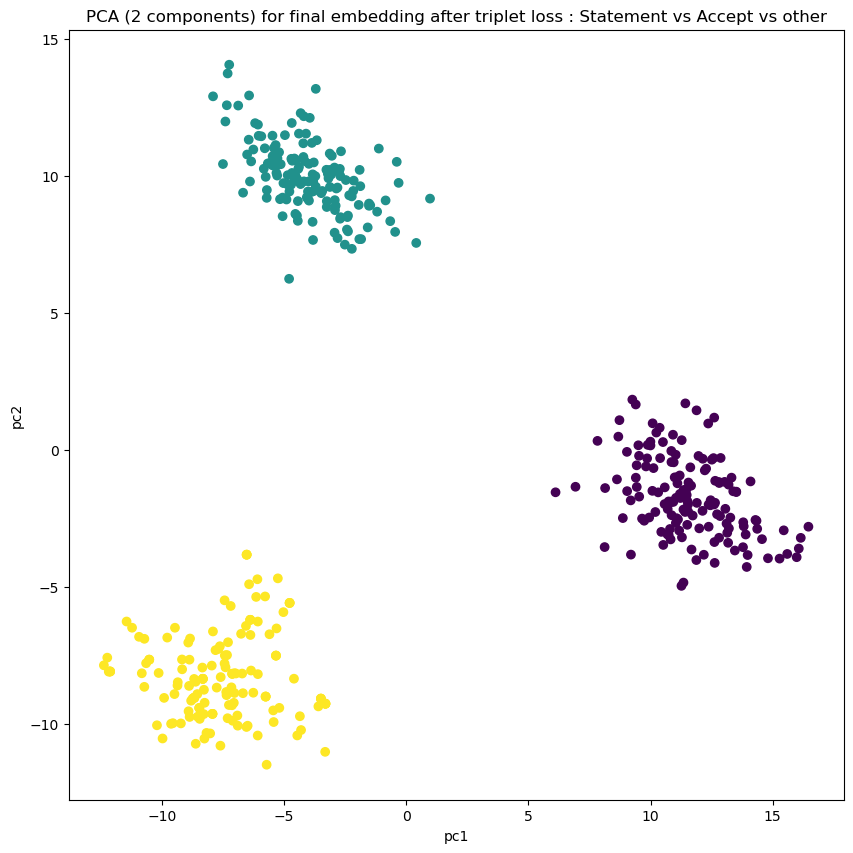

In [46]:
plt.figure(figsize=(10,10))
plt.scatter(x_pca[:,0],x_pca[:,1],c=targets.detach().numpy(), alpha=1)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title("PCA (2 components) for final embedding after triplet loss : Statement vs Accept vs other")

In [47]:
model, epoch_loss = rec_train(model, 100, 0.001, rec_train_loader, 2, hyperparam, modalities, output_size)

In [48]:
model, epoch_loss = rec_train(model, 200, 0.0001, rec_train_loader, 2, hyperparam, modalities, output_size)

In [49]:
epoch_loss[-10:]

[tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0., device='cuda:0', grad_fn=<DivBackward0>)]

In [50]:
true, pred, pred_probs = rec_test(model, rec_test_loader, 2, hyperparam, modalities, output_size)

In [51]:
print(true.unique(return_counts=True))
print(pred.unique(return_counts=True))

(tensor([0, 1, 2], dtype=torch.int32), tensor([19,  5,  1]))
(tensor([0, 1], dtype=torch.int32), tensor([21,  4]))


In [35]:
labels = ["Statement", "Accept", "Doubt"]

(array([0, 1, 2]),
 [Text(0, 0, 'Statement'), Text(1, 0, 'Accept'), Text(2, 0, 'Doubt')])

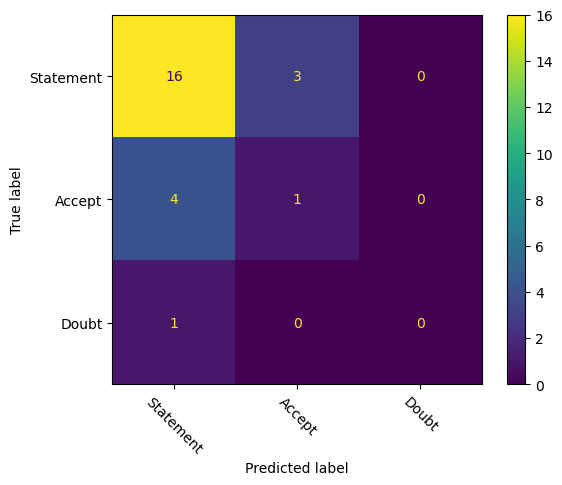

In [53]:
conf_matrix = confusion_matrix(true, pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=np.array(labels)[true.unique().tolist()].tolist()).plot()
plt.xticks(rotation=-45)

In [54]:
true = true.cpu()
pred = pred.cpu()
accuracy = accuracy_score(true, pred)

micro_f1_score = f1_score(true, pred, average="micro")
macro_f1_score = f1_score(true, pred, average="macro")
weighted_f1_score = f1_score(true, pred, average="weighted")

micro_precision = precision_score(true, pred, average="micro")
macro_precision = precision_score(true, pred, average="macro")
weighted_precision = precision_score(true, pred, average="weighted")

micro_recall = recall_score(true, pred, average="micro")
macro_recall = recall_score(true, pred, average="macro")
weighted_recall = recall_score(true, pred, average="weighted")

if output_size == 1:
    auroc = roc_auc_score(true.cpu(), pred_probs.cpu())
else: 
    auroc = roc_auc_score(true, pred_probs, multi_class='ovo')

In [55]:
print(f"accuracy : {accuracy:.4f}\n")

print(f"micro f1_score : {micro_f1_score:.4f}")
print(f"macro f1_score : {macro_f1_score:.4f}")
print(f"weighted f1_score : {weighted_f1_score:.4f}\n")

print(f"micro precision : {micro_precision:.4f}")
print(f"macro precision : {macro_precision:.4f}")
print(f"weighted precision : {weighted_precision:.4f}\n")

print(f"micro recall : {micro_recall:.4f}")
print(f"macro recall : {macro_recall:.4f}")
print(f"weighted recall : {weighted_recall:.4f}\n")

print(f"auroc : {auroc:.4f}")

accuracy : 0.6800

micro f1_score : 0.6800
macro f1_score : 0.3407
weighted f1_score : 0.6524

micro precision : 0.6800
macro precision : 0.3373
weighted precision : 0.6290

micro recall : 0.6800
macro recall : 0.3474
weighted recall : 0.6800

auroc : 0.3912


In [56]:
true, pred, pred_probs = rec_test(model, rec_val_loader, 2, hyperparam, modalities, output_size)

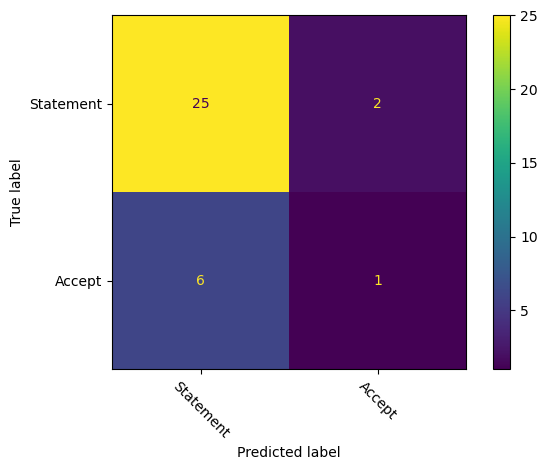

In [67]:
conf_matrix = confusion_matrix(true, pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=np.array(labels)[true.unique().tolist()].tolist()).plot()
plt.xticks(rotation=-45)
plt.tight_layout()
plt.savefig("test.jpg", dpi=200)

In [51]:
true = true.cpu()
pred = pred.cpu()
accuracy = accuracy_score(true, pred)

micro_f1_score = f1_score(true, pred, average="micro")
macro_f1_score = f1_score(true, pred, average="macro")
weighted_f1_score = f1_score(true, pred, average="weighted")

micro_precision = precision_score(true, pred, average="micro")
macro_precision = precision_score(true, pred, average="macro")
weighted_precision = precision_score(true, pred, average="weighted")

micro_recall = recall_score(true, pred, average="micro")
macro_recall = recall_score(true, pred, average="macro")
weighted_recall = recall_score(true, pred, average="weighted")

# if output_size == 1:
#     auroc = roc_auc_score(true.cpu(), pred_probs.cpu())
# else: 
#     auroc = roc_auc_score(true, pred_probs, multi_class='ovo')

In [52]:
print(f"accuracy : {accuracy:.4f}\n")

print(f"micro f1_score : {micro_f1_score:.4f}")
print(f"macro f1_score : {macro_f1_score:.4f}")
print(f"weighted f1_score : {weighted_f1_score:.4f}\n")

print(f"micro precision : {micro_precision:.4f}")
print(f"macro precision : {macro_precision:.4f}")
print(f"weighted precision : {weighted_precision:.4f}\n")

print(f"micro recall : {micro_recall:.4f}")
print(f"macro recall : {macro_recall:.4f}")
print(f"weighted recall : {weighted_recall:.4f}\n")

# print(f"auroc : {auroc:.4f}")

accuracy : 0.8235

micro f1_score : 0.8235
macro f1_score : 0.6483
weighted f1_score : 0.7943

micro precision : 0.8235
macro precision : 0.7527
weighted precision : 0.8033

micro recall : 0.8235
macro recall : 0.6243
weighted recall : 0.8235



Grid Search

In [53]:
LLMs = ["bert-base-uncased", "bert-large-uncased", "albert", "roberta", "xlm"]
n_folds = [5] # train test valid
window_sizes = [3]
lrs = [0.001]
output_sizes = [1, 8, 9] # [binary, multinomial without negatives, multinomial with all utterances]
bert_b_l = [True, False]
opensmile_b_l = [True, False]
action_b_l = [True, False]
gamr_b_l = [True, False]
cps_b_l = [True, False]
cps_f_b_l = [True, False]
lin_layers_l = [True, False]


In [54]:
# layer_sizes = [64, 128, 256, 384, 512, 768, 1024]
# layer_sizes = [128]
# layer_sizes = [3, 2]
# layer_sizes = [128, 256, 512]
# boo = [True, False]
# output_size = 3
# results_dataframe = pd.DataFrame()
# hyperparam = {"lin_layers":True, "hidden_size":512, "lstm_hidden_size":512, "lstm_input_size":128, "ff1_size":256, "ff2_size":384}
# modalities = {"bert_b":True, "opensmile_b":True, "cps_b":True, "cps_f_b":True, "action_b":True, "gamr_b":True}

# for LLM in LLMs:
#     for window_size in window_sizes:
#         test_group = 2
#         val_group = 5
#         train_data = get_data(test_group, val_group, window_size)
#         test_data = get_group_k(test_group, window_size)
#         val_data = get_group_k(val_group, window_size)
#         train_data = remove_non_cga(train_data)
#         test_data = remove_non_cga(test_data)
#         val_data = remove_non_cga(val_data)
#         train_dataset = rec_dataset(train_data, window_size)
#         test_dataset = rec_dataset(test_data, window_size)
#         val_dataset = rec_dataset(val_data, window_size)
#         smote_preprocess(train_dataset, window_size)
#         rec_train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
#         rec_test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)
#         rec_val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
        
#         for hid_size in layer_sizes:
#             for lstm_hid in layer_sizes:
#                 for lstm_inp in layer_sizes:
#                     for ff1 in layer_sizes:
#                         for ff2 in layer_sizes:
#                             for b in boo:
                                
#                                 hyperparam["hidden_size"] = hid_size
#                                 hyperparam["lstm_hidden_size"] = lstm_hid
#                                 hyperparam["lstm_input_size"] = lstm_inp
#                                 hyperparam["ff1_size"] = ff1
#                                 hyperparam["ff2_size"] = ff2
#                                 hyperparam["lin_layers"] = b

#                                 model = rec_common_ground(hyperparam, modalities, output_size=output_size)
#                                 model.to(device)
#                                 model = model_initilization(model)
#                                 model, epoch_loss = triplet_train(model, 200, 0.0001, rec_train_loader, hyperparam, modalities, output_size)

#                                 model, epoch_loss = rec_train(model, 100, 0.001, rec_train_loader, 2, hyperparam, modalities, output_size)
#                                 model, epoch_loss = rec_train(model, 200, 0.0001, rec_train_loader, 2, hyperparam, modalities, output_size)
#                                 true, pred, pred_probs = rec_test(model, rec_test_loader, 2, hyperparam, modalities, output_size)
#                                 true, pred = true.cpu(), pred.cpu()

#                                 accuracy = accuracy_score(true, pred)

#                                 micro_f1_score = f1_score(true, pred, average="micro")
#                                 macro_f1_score = f1_score(true, pred, average="macro")
#                                 weighted_f1_score = f1_score(true, pred, average="weighted")

#                                 micro_precision = precision_score(true, pred, average="micro")
#                                 macro_precision = precision_score(true, pred, average="macro")
#                                 weighted_precision = precision_score(true, pred, average="weighted")

#                                 micro_recall = recall_score(true, pred, average="micro")
#                                 macro_recall = recall_score(true, pred, average="macro")
#                                 weighted_recall = recall_score(true, pred, average="weighted")

#                                 auroc = roc_auc_score(true, pred_probs, multi_class='ovo')


#                                 true, pred, pred_probs = rec_test(model, rec_val_loader, 2, hyperparam, modalities, output_size)

#                                 true = true.cpu()
#                                 pred = pred.cpu()
#                                 accuracy_val = accuracy_score(true, pred)

#                                 micro_f1_score_val = f1_score(true, pred, average="micro")
#                                 macro_f1_score_val = f1_score(true, pred, average="macro")
#                                 weighted_f1_score_val = f1_score(true, pred, average="weighted")

#                                 micro_precision_val = precision_score(true, pred, average="micro")
#                                 macro_precision_val = precision_score(true, pred, average="macro")
#                                 weighted_precision_val = precision_score(true, pred, average="weighted")

#                                 micro_recall_val = recall_score(true, pred, average="micro")
#                                 macro_recall_val = recall_score(true, pred, average="macro")
#                                 weighted_recall_val = recall_score(true, pred, average="weighted")

#                                 results_dataframe=pd.concat([results_dataframe,pd.DataFrame({'lin_layers':[b],
#                                                                                                 'hidden_size':[hyperparam["hidden_size"]],
#                                                                                                 'lstm_hidden_size':[hyperparam["lstm_hidden_size"]],
#                                                                                                 'lstm_input_size':[hyperparam["lstm_input_size"]],
#                                                                                                 'ff1_size':[hyperparam["ff1_size"]],
#                                                                                                 'ff2_size':[hyperparam["ff2_size"]],
#                                                                                                 'epochs':[300],
#                                                                                                 'llm':[LLM],
#                                                                                                 'train_loss':[epoch_loss[-1].item()],
#                                                                                                 'accuracy_test':[accuracy],
#                                                                                                 'micro_f1_score_test':[micro_f1_score],
#                                                                                                 'macro_f1_score_test':[macro_f1_score],
#                                                                                                 'weighted_f1_score_test':[weighted_f1_score],
#                                                                                                 'micro_precision_test':[micro_precision],
#                                                                                                 'macro_precision_test':[macro_precision],
#                                                                                                 'weighted_precision_test':[weighted_precision],
#                                                                                                 'micro_recall_test':[micro_recall],
#                                                                                                 'macro_recall_test':[macro_recall],
#                                                                                                 'weighted_recall_test':[weighted_recall],
#                                                                                                 'auroc_test':[auroc],
#                                                                                                 'accuracy_val':[accuracy_val],
#                                                                                                 'micro_f1_score_val':[micro_f1_score_val],
#                                                                                                 'macro_f1_score_val':[macro_f1_score_val],
#                                                                                                 'weighted_f1_score_val':[weighted_f1_score_val],
#                                                                                                 'micro_precision_val':[micro_precision_val],
#                                                                                                 'macro_precision_val':[macro_precision_val],
#                                                                                                 'weighted_precision_val':[weighted_precision_val],
#                                                                                                 'micro_recall_val':[micro_recall_val],
#                                                                                                 'macro_recall_val':[macro_recall_val],
#                                                                                                 'weighted_recall_val':[weighted_recall_val]})])
#                                 results_dataframe.to_csv("multinomial_triplet_loss.csv", index=False)
#                                 model_name = f"{str(LLM)}"
#                                 for hyp in hyperparam.values():
#                                     model_name += '_'+str(hyp)
#                                 torch.save(model, f"save_triplet/{model_name}.pt")


In [35]:
window_size = 3
output_size = 3
hyperparam = {"lin_layers":True, "hidden_size":256, "lstm_hidden_size":512, "lstm_input_size":512, "ff1_size":512, "ff2_size":512}
modalities = {"bert_b":True, "opensmile_b":True, "cps_b":True, "cps_f_b":True, "action_b":True, "gamr_b":True}
labels = ["Statement", "Accept", "Doubt"]

accuracies = []
micro_f1_scores = []
macro_f1_scores = []
weighted_f1_scores = []
micro_precisions = []
macro_precisions = []
weighted_precisions = []
micro_recalls = []
macro_recalls = []
weighted_recalls = []
aurocs = []

for group in range(1, 11):
    torch.manual_seed(30)
    torch.cuda.manual_seed(30)
    train_data = get_data(group, 12, window_size)
    test_data = get_group_k(group, window_size)
    train_data = remove_non_cga(train_data)
    test_data = remove_non_cga(test_data)
    train_dataset = rec_dataset(train_data, window_size)
    test_dataset = rec_dataset(test_data, window_size)
    smote_preprocess(train_dataset, window_size)
    rec_train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    rec_test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

    model = rec_common_ground(hyperparam, modalities, output_size=output_size)
    model.to(device)
    model = model_initilization(model)
    # model, epoch_loss = triplet_train(model, 200, 0.0001, rec_train_loader, hyperparam, modalities, output_size)

    model, epoch_loss = rec_train(model, 100, 0.001, rec_train_loader, 2, hyperparam, modalities, output_size)
    # model, epoch_loss = rec_train(model, 200, 0.0001, rec_train_loader, 2, hyperparam, modalities, output_size)
    # model = torch.load(f"best_triplet_{group:02d}.pt")
    model, epoch_loss = rec_train(model, 100, 0.0001, rec_train_loader, 2, hyperparam, modalities, output_size)
    true, pred, pred_probs = rec_test(model, rec_test_loader, 2, hyperparam, modalities, output_size)
    true, pred = true.cpu(), pred.cpu()

    accuracy = accuracy_score(true, pred)

    micro_f1_score = f1_score(true, pred, average="micro")
    macro_f1_score = f1_score(true, pred, average="macro")
    weighted_f1_score = f1_score(true, pred, average="weighted")

    micro_precision = precision_score(true, pred, average="micro")
    macro_precision = precision_score(true, pred, average="macro")
    weighted_precision = precision_score(true, pred, average="weighted")

    micro_recall = recall_score(true, pred, average="micro")
    macro_recall = recall_score(true, pred, average="macro")
    weighted_recall = recall_score(true, pred, average="weighted")
    conf_matrix = confusion_matrix(true, pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=np.array(labels)[true.unique().tolist()].tolist()).plot()
    plt.xticks(rotation=-45)
    plt.tight_layout()
    plt.savefig(f"cm_{group:02d}.jpg", dpi=200)

    try:
        auroc = roc_auc_score(true, pred_probs, multi_class='ovo')
    except:
        auroc = 0.5

    accuracies.append(accuracy)
    micro_f1_scores.append(micro_f1_score)
    macro_f1_scores.append(macro_f1_score)
    weighted_f1_scores.append(weighted_f1_score)
    micro_precisions.append(micro_precision)
    macro_precisions.append(macro_precision)
    weighted_precisions.append(weighted_precision)
    micro_recalls.append(micro_recall)
    macro_recalls.append(macro_recall)
    weighted_recalls.append(weighted_recall)
    aurocs.append(auroc)

    torch.save(model, f"best_triplet_{group:02d}.pt")


In [ ]:
def avg(l):
    return sum(l)/len(l)

In [ ]:
print(accuracies)
print(avg(accuracies))

[0.625, 0.72, 0.75, 0.5, 0.7352941176470589, 0.6896551724137931, 0.42857142857142855, 0.5555555555555556, 0.8333333333333334, 0.4375]
0.627490960752117


In [ ]:
np.array(accuracies).std()

0.13361279024410777

In [ ]:
print(micro_f1_scores)
print(avg(micro_f1_scores))

[0.625, 0.72, 0.75, 0.5, 0.735294117647059, 0.6896551724137931, 0.42857142857142855, 0.5555555555555556, 0.8333333333333334, 0.4375]
0.627490960752117


In [ ]:
print(macro_f1_scores)
print(avg(macro_f1_scores))

[0.5636363636363636, 0.35975609756097565, 0.6210526315789474, 0.2352941176470588, 0.5119617224880383, 0.3752913752913753, 0.27116704805491987, 0.38888888888888884, 0.6516129032258065, 0.2028985507246377]
0.41815596990970116


In [ ]:
print(weighted_f1_scores)
print(avg(weighted_f1_scores))

[0.6045454545454545, 0.6802439024390244, 0.7684210526315791, 0.41176470588235287, 0.7061638052350128, 0.737159392331806, 0.4527078565980167, 0.5092592592592592, 0.7913978494623656, 0.3423913043478261]
0.6004054582732697


In [ ]:
print(micro_precisions)
print(avg(micro_precisions))

[0.625, 0.72, 0.75, 0.5, 0.7352941176470589, 0.6896551724137931, 0.42857142857142855, 0.5555555555555556, 0.8333333333333334, 0.4375]
0.627490960752117


In [ ]:
print(macro_precisions)
print(avg(macro_precisions))

[0.5833333333333333, 0.3686868686868687, 0.611111111111111, 0.19999999999999998, 0.525, 0.3824561403508772, 0.2883064516129032, 0.35497835497835495, 0.9117647058823529, 0.16666666666666666]
0.43923036326224685


In [ ]:
print(weighted_precisions)
print(avg(weighted_precisions))

[0.6041666666666666, 0.6539393939393939, 0.7962962962962963, 0.35000000000000003, 0.6867647058823529, 0.8373865698729582, 0.5255376344086021, 0.47258297258297255, 0.8627450980392157, 0.28125]
0.6070669337688459


In [ ]:
print(micro_recalls)
print(avg(micro_recalls))

[0.625, 0.72, 0.75, 0.5, 0.7352941176470589, 0.6896551724137931, 0.42857142857142855, 0.5555555555555556, 0.8333333333333334, 0.4375]
0.627490960752117


In [ ]:
print(macro_recalls)
print(avg(macro_recalls))

[0.5666666666666667, 0.3649122807017544, 0.65, 0.2857142857142857, 0.5158730158730158, 0.46222222222222226, 0.2984126984126984, 0.4333333333333333, 0.625, 0.25925925925925924]
0.4461393762183235


In [ ]:
print(weighted_recalls)
print(avg(weighted_recalls))

[0.625, 0.72, 0.75, 0.5, 0.7352941176470589, 0.6896551724137931, 0.42857142857142855, 0.5555555555555556, 0.8333333333333334, 0.4375]
0.627490960752117


In [ ]:
print(aurocs)
print(avg(aurocs))

[0.5, 0.5385964912280702, 0.5, 0.5634920634920635, 0.5, 0.5011111111111111, 0.4757936507936507, 0.668888888888889, 0.5, 0.5305836139169472]
0.5278465819430733


Done:

check if any loss of CGA when using google's segments/oracle

implement for loop for data processing with variable window size

change window size

format of model's input must be changed to list (update)

try bert only and opensmile only (update)

change architecture try less layers (update) (use LSTM only)

oracle segments

bert roberta albert xlm bert large

change openBERT

fix oracle mapping of cga

oracle segmentations and transcripts

set up cps (facet level (but make it interchangeable)) (check count vs train_datasets.targets)

map cps to oracle 

gamr arg1 list

map action and gamr to oracle

set up actions

GAMR feature input (discuss with ken on Thursday) (problem with group 4 and 6 (tier0 and tier1 instead of participant_1, 2 and 3))

check if gamr is exclusive with oracle

change window size function

set up grid search 

Train the biggest model (using GPU) (all modalities, 200 epochs, all 10 groups, with lin_layers, )

switch to multinomial + oracle check with 0s (instances where there's absence of cg), then without (only train on utterances with at least 1 cg) (loop through dataset and check last label for each utterance sequence, if 0 remove) (must change criterion)


If imbalance problem still arises: add scaler, tune loss function to weighted loss  

remove "None" label from target

auroc 

how resampling works 

model initialization

set random seed to a fixed state

group 5 as test => constrained to use group 2 to get auroc => poor results (even with increased weights)

increase weight for statement, accept and doubt

Try SMOTE 

add loss of last epoch in model tracking CSV file in grid search

fine tune models (hyperparams)+llm selection+ablation study (use dict for hyperparams)

metric learning

change grid search to account for smote, and val set results

add gold standard data

set torch.manual_seed(44) # different from cuda

Run grid search

make model diagram

make 10 hold one group out models with best architecture


TO DO:

train for more epochs and less learning rate the saved models

compare with different LLMs

all, each, speech+prosody, speech+gesture, action+cps, speech+each
